In [1]:
import numpy as np
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv

%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

import os 
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters

from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

from keras.initializers import glorot_uniform

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(1)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
import random as python_random
python_random.seed(41)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
from tensorflow import set_random_seed
set_random_seed(42)

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
train = pd.read_csv("data/7C_train.csv", sep="\t")
valid = pd.read_csv("data/7C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'valid sequences')

3229 train sequences
710 valid sequences


In [4]:
train.head(10)

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),CS Position,Signal Peptide Seq
0,Q9GZS1,Large Protein Complex,High,MAAEVLPSARWQYCGAPDGSQRAVLVQFSNGKLQSPGNMRFTLYEN...,419,0.15,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000870,[],0000000000000000000000000000000000000000000000...
1,Q9BV79,Mitochondrion,Low,MWVCSTLWRVRTPARQWRGLLPASGCHGPAASSYSASAEPARVRAL...,373,0.32,0.01,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.006977,[],0000000000000000000000000000000000000000000000...
2,P30153,Large Protein Complex,Very High,MAAADGDDSLYPIAVLIDELRNEDVQLRLNSIKKLSTIALALGVER...,589,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000542,[],0000000000000000000000000000000000000000000000...
3,P62308,Large Protein Complex,Very High,MSKAHPPELKKFMDKKLSLKLNGGRHVQGILRGFDPFMNLVIDECV...,76,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000583,[],0000000000000000000000000000000000000000000000...
4,Q92888,Large Protein Complex,Very High,MEDFARGAASPGPSRPGLVPVSIIGAEDEDFENELETNSEEQNSQF...,912,0.00,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000912,[],0000000000000000000000000000000000000000000000...
5,P31946,Large Protein Complex,Very High,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,246,0.04,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000383,[],0000000000000000000000000000000000000000000000...
6,O75882,ER,Very Low,MVAAAAATEARLRRRTAATAALAGRSGGPHWDWDVTRAGRPGLGAG...,1429,26.26,0.05,1,['1279-1301'],0000000000000000000000000000000000000000000000...,OTHER,0.089563,[],0000000000000000000000000000000000000000000000...
7,P53004,Large Protein Complex,High,MNAEPERKFGVVVVGVGRAGSVRMRDLRNPHPSSAFLNLIGFVSRR...,296,0.35,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000697,[],0000000000000000000000000000000000000000000000...
8,P78330,Large Protein Complex,Very Low,MVSHSELRKLFYSADAVCFDVDSTVIREEGIDELAKICGVEDAVSE...,225,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.001496,[],0000000000000000000000000000000000000000000000...
9,P35611,Large Protein Complex,High,MNGDSRAAVVTSPPPTTAPHKERYFDRVDENNPEYLRERNMAPDLR...,737,0.06,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000577,[],0000000000000000000000000000000000000000000000...


In [22]:
train.dtypes

Lead Protein ID            object
Compartment Prediction     object
Prediction Confidence      object
Sequence                   object
Sequence Lengh              int64
ExpAA                     float64
First60                   float64
PredHel                     int64
Topology                   object
Topology Seq               object
Prediction                 object
SP(Sec/SPI)               float64
CS Position                object
Signal Peptide Seq         object
dtype: object

In [5]:
train_helix = train["Topology Seq"]
valid_helix = valid["Topology Seq"]

train_signalP = train["Signal Peptide Seq"]
valid_signalP = valid["Signal Peptide Seq"]

In [6]:
max_len = 1500
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [7]:
# NB: DO NOT USE SET, IT CHANGES ORDER OF CATEGORY EVERYTIME I RUN THE NOTEBOOK!!!!
#cat = list(set(y_train))
cat = ['ER',
 'Golgi',
 'Mitochondrion',
 'Endosome',
 'Large Protein Complex',
 'Plasma membrane',
 'Lysosome']

In [8]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [9]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [10]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [11]:
# Function to convert sequences to array of indices. I will use that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [12]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [13]:
def convert_to_list(column):
    new = []
    for seq in column:
        new.append(list(map(int, seq)))
    return new

In [14]:
train_helix = convert_to_list(train_helix)
valid_helix = convert_to_list(valid_helix)

train_signalP = convert_to_list(train_signalP)
valid_signalP = convert_to_list(valid_signalP)

In [15]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (3229, 1500)
x_valid shape: (710, 1500)


In [16]:
train_helix_pad = sequence.pad_sequences(train_helix, maxlen=max_len, value=0)
valid_helix_pad = sequence.pad_sequences(valid_helix, maxlen=max_len, value=0)

train_signalP_pad = sequence.pad_sequences(train_signalP, maxlen=max_len, value=0)
valid_signalP_pad = sequence.pad_sequences(valid_signalP, maxlen=max_len, value=0)

In [17]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [18]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

## Model 1:
### simple LTSM, attention without feature

Instructions for updating:
Colocations handled automatically by placer.


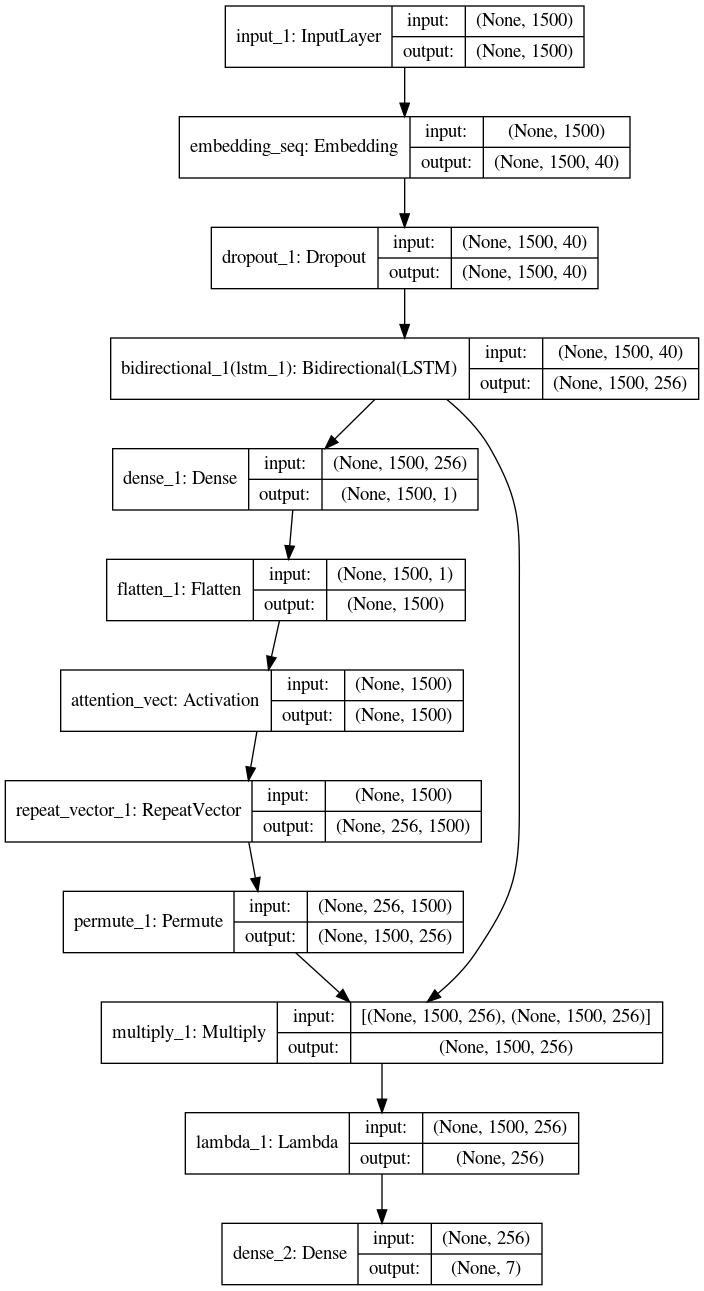

In [21]:
max_aa = tot_aa
max_feature = 2
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 40
feature_embedding_size = 1
# Convolution
filters = 20
pool_size = 2

input_seq = Input(shape=[max_len], dtype='int32')
input_helix = Input(shape=[max_len], dtype='int32')
input_signalP = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded_seq = Embedding(input_dim=max_aa,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_seq', trainable=True, mask_zero=False)(input_seq)

drop = Dropout(0.2)(embedded_seq)
# Convolution layer of different size


activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(drop)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=input_seq, outputs=probabilities)

plot_model(model, to_file='models_simpleLSTM/model1_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_simpleLSTM/model1_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 3229 samples, validate on 710 samples
Epoch 1/60
3229/3229 [==============================] - 371s 115ms/step - loss: 1.5215 - accuracy: 0.5178 - val_loss: 1.4547 - val_accuracy: 0.5197

Epoch 00001: val_loss improved from inf to 1.45468, saving model to models_simpleLSTM/model1_weights.hdf5
Epoch 2/60
3229/3229 [==============================] - 357s 110ms/step - loss: 1.4457 - accuracy: 0.5169 - val_loss: 1.3972 - val_accuracy: 0.5211

Epoch 00002: val_loss improved from 1.45468 to 1.39716, saving model to models_simpleLSTM/model1_weights.hdf5
Epoch 3/60
3229/3229 [==============================] - 360s 111ms/step - loss: 1.4328 - accuracy: 0.5172 - val_loss: 1.3073 - val_accuracy: 0.5352

Epoch 00003: val_loss improved from 1.39716 to 1.30730, saving model to models_simpleLSTM/model1_weights.hdf5
Epoch 4/60
3229/3229 [==============================] - 365s 113ms/step - loss: 1.3080 - accuracy: 0.5550 - val_loss: 1.4124 - val_a


Epoch 00035: val_loss improved from 0.97382 to 0.95525, saving model to models_simpleLSTM/model1_weights.hdf5
Epoch 36/60
3229/3229 [==============================] - 309s 96ms/step - loss: 1.0164 - accuracy: 0.6835 - val_loss: 0.9418 - val_accuracy: 0.7183

Epoch 00036: val_loss improved from 0.95525 to 0.94180, saving model to models_simpleLSTM/model1_weights.hdf5
Epoch 37/60
3229/3229 [==============================] - 313s 97ms/step - loss: 1.0042 - accuracy: 0.6894 - val_loss: 0.9424 - val_accuracy: 0.7000

Epoch 00037: val_loss did not improve from 0.94180
Epoch 38/60
3229/3229 [==============================] - 335s 104ms/step - loss: 0.9972 - accuracy: 0.6850 - val_loss: 0.9304 - val_accuracy: 0.7113

Epoch 00038: val_loss improved from 0.94180 to 0.93040, saving model to models_simpleLSTM/model1_weights.hdf5
Epoch 39/60
3229/3229 [==============================] - 333s 103ms/step - loss: 0.9942 - accuracy: 0.6937 - val_loss: 0.9303 - val_accuracy: 0.7070

Epoch 00039: val_los

In [85]:
def history_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

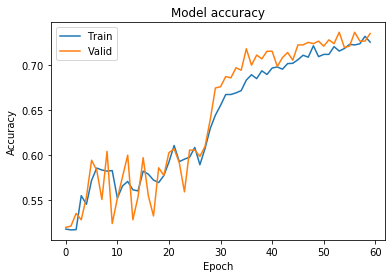

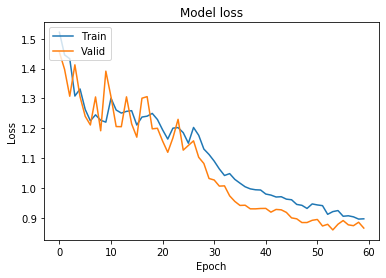

In [24]:
history_plot(history)

In [27]:
model = load_model('models_simpleLSTM/model1_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.8598212648445451, 0.7366197109222412]

In [74]:
# Keep training that model
model = load_model('models_simpleLSTM/model1_weights.hdf5')
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_simpleLSTM/model1_2_weights.hdf5',
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=20,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 3229 samples, validate on 710 samples
Epoch 1/20
3229/3229 [==============================] - 332s 103ms/step - loss: 0.9243 - accuracy: 0.7281 - val_loss: 0.8777 - val_accuracy: 0.7268

Epoch 00001: val_loss improved from inf to 0.87769, saving model to models_simpleLSTM/model1_2_weights.hdf5
Epoch 2/20
3229/3229 [==============================] - 323s 100ms/step - loss: 0.9172 - accuracy: 0.7185 - val_loss: 0.8912 - val_accuracy: 0.7141

Epoch 00002: val_loss did not improve from 0.87769
Epoch 3/20
3229/3229 [==============================] - 312s 97ms/step - loss: 0.9073 - accuracy: 0.7278 - val_loss: 0.8625 - val_accuracy: 0.7324

Epoch 00003: val_loss improved from 0.87769 to 0.86249, saving model to models_simpleLSTM/model1_2_weights.hdf5
Epoch 4/20
3229/3229 [==============================] - 312s 96ms/step - loss: 0.9113 - accuracy: 0.7275 - val_loss: 0.8670 - val_accuracy: 0.7408

Epoch 00004: val_loss did not improve from 0.86249
Epoch 5/20
3229/3229 [===============

In [88]:
model = load_model('models_simpleLSTM/model1_2_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.845874008998065, 0.7450703978538513]

In [89]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

In [ ]:
def confusion_plot(y_valid, y_pred_label, cat):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

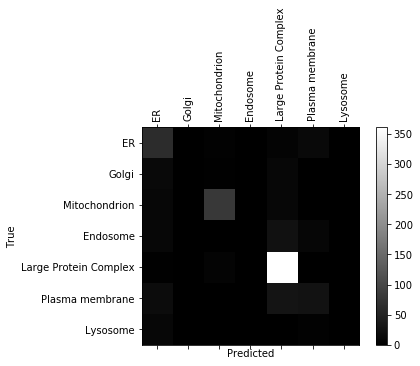

In [90]:
confusion_plot(y_valid, y_pred_label, cat)

In [91]:
def confusion_plot_norm(y_valid, y_pred_label, cat, axis=1):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx / (conf_mx.max(axis=axis)+1), cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(conf_mx)

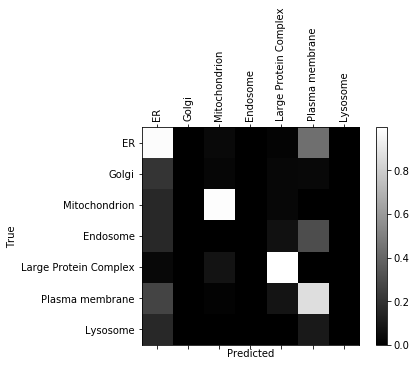

In [92]:
conf = confusion_plot_norm(y_valid, y_pred_label, cat, axis=1)

In [93]:
conf

array([[ 63,   0,   3,   0,   6,  13,   0],
       [ 13,   0,   2,   0,  11,   1,   0],
       [ 10,   0,  79,   0,  11,   0,   0],
       [ 10,   0,   0,   0,  24,   9,   0],
       [  2,   0,   6,   0, 361,   0,   0],
       [ 17,   0,   1,   0,  29,  26,   0],
       [ 10,   0,   0,   0,   0,   3,   0]])

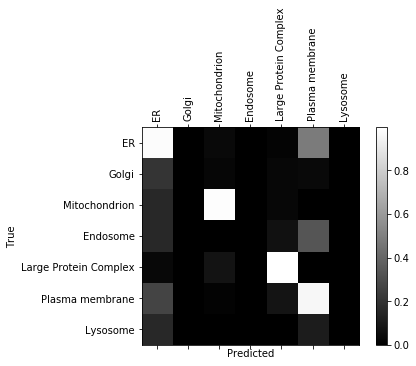

array([[ 63,   0,   3,   0,   6,  13,   0],
       [ 13,   0,   2,   0,  11,   1,   0],
       [ 10,   0,  79,   0,  11,   0,   0],
       [ 10,   0,   0,   0,  24,   9,   0],
       [  2,   0,   6,   0, 361,   0,   0],
       [ 17,   0,   1,   0,  29,  26,   0],
       [ 10,   0,   0,   0,   0,   3,   0]])

In [94]:
confusion_plot_norm(y_valid, y_pred_label, cat, axis=0)

In [81]:
print(classification_report(y_valid, y_pred_label))

                       precision    recall  f1-score   support

                   ER       0.50      0.74      0.60        85
             Endosome       0.00      0.00      0.00        43
                Golgi       0.00      0.00      0.00        27
Large Protein Complex       0.82      0.98      0.89       369
             Lysosome       0.00      0.00      0.00        13
        Mitochondrion       0.87      0.79      0.83       100
      Plasma membrane       0.50      0.36      0.42        73

             accuracy                           0.75       710
            macro avg       0.38      0.41      0.39       710
         weighted avg       0.66      0.75      0.69       710



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 2
### Simple LSTM with attention with extra features

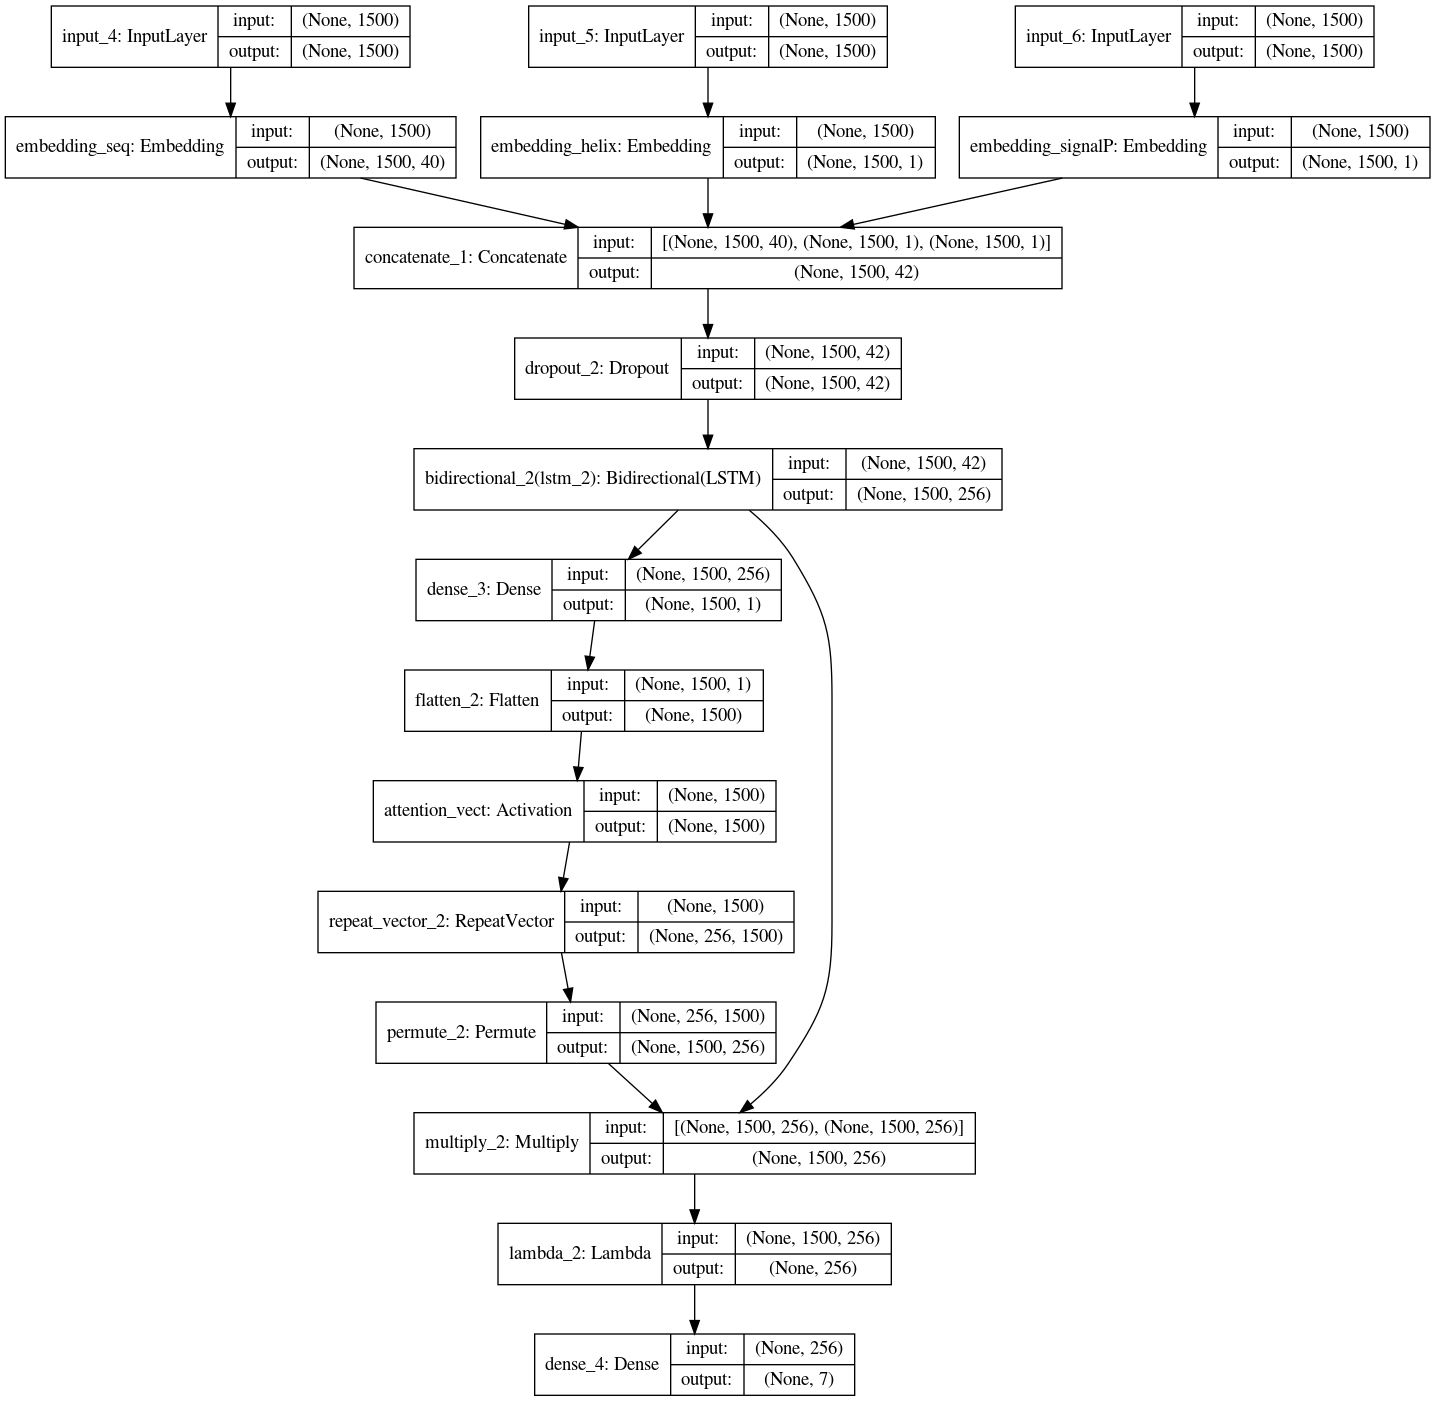

In [35]:
max_aa = tot_aa
max_feature = 2
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 40
feature_embedding_size = 1
# Convolution
filters = 20
pool_size = 2

input_seq = Input(shape=[max_len], dtype='int32')
input_helix = Input(shape=[max_len], dtype='int32')
input_signalP = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded_seq = Embedding(input_dim=max_aa,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_seq', trainable=True, mask_zero=False)(input_seq)

embedded_helix = Embedding(input_dim=max_feature,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_helix', trainable=True, mask_zero=False)(input_helix)

embedded_signalP = Embedding(input_dim=max_feature,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_signalP', trainable=True, mask_zero=False)(input_signalP)

concat_input = concatenate([embedded_seq, embedded_helix, embedded_signalP], axis=2)

drop = Dropout(0.2)(concat_input)
# Convolution layer of different size


activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(drop)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model2 = Model(inputs=[input_seq, input_helix, input_signalP], outputs=probabilities)

plot_model(model2, to_file='models_simpleLSTM/model2_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model2.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_simpleLSTM/model2_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history2 = model2.fit([x_train_pad, train_helix_pad, train_signalP_pad], y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[[x_valid_pad, valid_helix_pad, valid_signalP_pad], y_valid_OH], callbacks=[ckpt])

Train on 3229 samples, validate on 710 samples
Epoch 1/60
3229/3229 [==============================] - 487s 151ms/step - loss: 1.5221 - accuracy: 0.5150 - val_loss: 1.4626 - val_accuracy: 0.5197

Epoch 00001: val_loss improved from inf to 1.46256, saving model to models_simpleLSTM/model2_weights.hdf5
Epoch 2/60
3229/3229 [==============================] - 443s 137ms/step - loss: 1.4262 - accuracy: 0.5317 - val_loss: 1.2473 - val_accuracy: 0.5944

Epoch 00002: val_loss improved from 1.46256 to 1.24734, saving model to models_simpleLSTM/model2_weights.hdf5
Epoch 3/60
3229/3229 [==============================] - 494s 153ms/step - loss: 1.3344 - accuracy: 0.5627 - val_loss: 1.2370 - val_accuracy: 0.5958

Epoch 00003: val_loss improved from 1.24734 to 1.23697, saving model to models_simpleLSTM/model2_weights.hdf5
Epoch 4/60
3229/3229 [==============================] - 401s 124ms/step - loss: 1.2887 - accuracy: 0.5732 - val_loss: 1.2379 - val_accuracy: 0.5845

Epoch 00004: val_loss did not i

3229/3229 [==============================] - 314s 97ms/step - loss: 1.0678 - accuracy: 0.6531 - val_loss: 1.0053 - val_accuracy: 0.6873

Epoch 00038: val_loss improved from 1.04804 to 1.00533, saving model to models_simpleLSTM/model2_weights.hdf5
Epoch 39/60
3229/3229 [==============================] - 318s 99ms/step - loss: 1.0471 - accuracy: 0.6643 - val_loss: 0.9837 - val_accuracy: 0.6958

Epoch 00039: val_loss improved from 1.00533 to 0.98370, saving model to models_simpleLSTM/model2_weights.hdf5
Epoch 40/60
3229/3229 [==============================] - 313s 97ms/step - loss: 1.0180 - accuracy: 0.6770 - val_loss: 0.9662 - val_accuracy: 0.6958

Epoch 00040: val_loss improved from 0.98370 to 0.96623, saving model to models_simpleLSTM/model2_weights.hdf5
Epoch 41/60
3229/3229 [==============================] - 316s 98ms/step - loss: 1.0185 - accuracy: 0.6751 - val_loss: 0.9495 - val_accuracy: 0.6930

Epoch 00041: val_loss improved from 0.96623 to 0.94953, saving model to models_simpleL

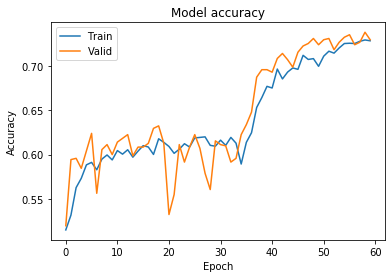

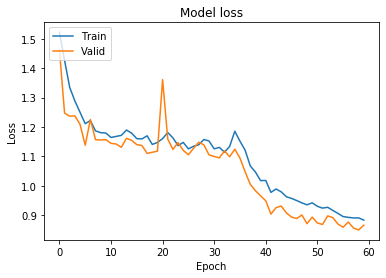

In [37]:
history_plot(history2)

In [72]:
# Keep training that model
model2 = load_model('models_simpleLSTM/model2_weights.hdf5')
model2.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_simpleLSTM/model2_2_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history2_2 = model2.fit([x_train_pad, train_helix_pad, train_signalP_pad], y_train_OH, 
                    batch_size=32, epochs=20,
                    class_weight = class_weights,
          validation_data=[[x_valid_pad, valid_helix_pad, valid_signalP_pad], y_valid_OH], callbacks=[ckpt])

Train on 3229 samples, validate on 710 samples
Epoch 1/20
3229/3229 [==============================] - 419s 130ms/step - loss: 0.8838 - accuracy: 0.7296 - val_loss: 0.8697 - val_accuracy: 0.7239

Epoch 00001: val_loss improved from inf to 0.86966, saving model to models_simpleLSTM/model2_2_weights.hdf5
Epoch 2/20
3229/3229 [==============================] - 357s 110ms/step - loss: 0.8757 - accuracy: 0.7337 - val_loss: 0.8753 - val_accuracy: 0.7254

Epoch 00002: val_loss did not improve from 0.86966
Epoch 3/20
3229/3229 [==============================] - 366s 113ms/step - loss: 0.8850 - accuracy: 0.7272 - val_loss: 0.8641 - val_accuracy: 0.7324

Epoch 00003: val_loss improved from 0.86966 to 0.86408, saving model to models_simpleLSTM/model2_2_weights.hdf5
Epoch 4/20
3229/3229 [==============================] - 388s 120ms/step - loss: 0.8679 - accuracy: 0.7371 - val_loss: 0.8506 - val_accuracy: 0.7352

Epoch 00004: val_loss improved from 0.86408 to 0.85063, saving model to models_simpleL

In [82]:
model2 = load_model('models_simpleLSTM/model2_2_weights.hdf5')
model2.evaluate([x_valid_pad, valid_helix_pad, valid_signalP_pad], y_valid_OH, verbose=0)

[0.8292661059070641, 0.7422535419464111]

In [83]:
y_pred2 = model2.predict([x_valid_pad, valid_helix_pad, valid_signalP_pad])
y_pred_indices2 = OH_to_label_indices(y_pred2)
y_pred_label2 = indices_to_cat(y_pred_indices2)

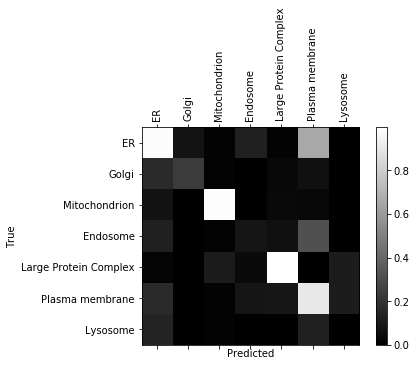

array([[ 54,   1,   1,   3,   5,  21,   0],
       [  9,   3,   1,   0,  12,   2,   0],
       [  4,   0,  82,   0,  13,   1,   0],
       [  7,   0,   1,   2,  23,  10,   0],
       [  1,   0,   9,   1, 357,   0,   1],
       [  9,   0,   1,   2,  31,  29,   1],
       [  8,   0,   1,   0,   0,   4,   0]])

In [84]:
confusion_plot_norm(y_valid, y_pred_label2, cat, axis=1)

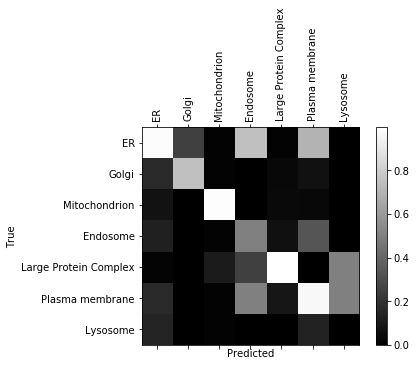

array([[ 54,   1,   1,   3,   5,  21,   0],
       [  9,   3,   1,   0,  12,   2,   0],
       [  4,   0,  82,   0,  13,   1,   0],
       [  7,   0,   1,   2,  23,  10,   0],
       [  1,   0,   9,   1, 357,   0,   1],
       [  9,   0,   1,   2,  31,  29,   1],
       [  8,   0,   1,   0,   0,   4,   0]])

In [85]:
confusion_plot_norm(y_valid, y_pred_label2, cat, axis=0)

In [86]:
print(classification_report(y_valid, y_pred_label2))

                       precision    recall  f1-score   support

                   ER       0.59      0.64      0.61        85
             Endosome       0.25      0.05      0.08        43
                Golgi       0.75      0.11      0.19        27
Large Protein Complex       0.81      0.97      0.88       369
             Lysosome       0.00      0.00      0.00        13
        Mitochondrion       0.85      0.82      0.84       100
      Plasma membrane       0.43      0.40      0.41        73

             accuracy                           0.74       710
            macro avg       0.53      0.43      0.43       710
         weighted avg       0.70      0.74      0.70       710



# Model 3: 

Adding features separately from the LSTM AND in LSTM.
Features added:
- "ExpAA=": The expected number of amino acids intransmembrane helices (see above).
- "First60=": The expected number of amino acids in transmembrane helices in the first 60 amino acids of the protein (see above).
- "PredHel=": The number of predicted transmembrane helices by N-best.


- "Prediction": Other or SP(Sec/SPI), need to be one hot encoded to 0 for other and 1 for SP(Sec/SPI)
- "SP(Sec/SPI)" probabilities.

In [26]:
# preparing features
pred_train = train['Prediction']
pred_valid = valid['Prediction']

In [24]:
def pred_OH(pred):
    oh = []
    for p in pred:
        if p == 'OTHER':
            oh.append(0)
        else:
            oh.append(1)
    return oh

In [40]:
train['Prediction_OH'] = oh_pred_train
valid['Prediction_OH'] = oh_pred_valid
features_train = train[['ExpAA', 'First60', 'PredHel', 'SP(Sec/SPI)', 'Prediction_OH']]
features_valid = valid[['ExpAA', 'First60', 'PredHel', 'SP(Sec/SPI)', 'Prediction_OH']]
features_train.head()

,ExpAA,First60,PredHel,SP(Sec/SPI),Prediction_OH
0,0.15,0.00,0,0.000870,0
1,0.32,0.01,0,0.006977,0
2,0.01,0.00,0,0.000542,0
3,0.01,0.00,0,0.000583,0
4,0.00,0.00,0,0.000912,0


In [42]:
features_train.dtypes

ExpAA            float64
First60          float64
PredHel            int64
SP(Sec/SPI)      float64
Prediction_OH      int64
dtype: object

In [81]:
# Feautures ready to use 

ExpAA_train = np.array(train['ExpAA'])
First60_train = np.array(train['First60'])
PredHel_train = np.array(train['PredHel'])
SP_train = np.array(train['SP(Sec/SPI)'])
oh_pred_train = np.array(pred_OH(pred_train))

ExpAA_valid = np.array(valid['ExpAA'])
First60_valid = np.array(valid['First60'])
PredHel_valid = np.array(valid['PredHel'])
SP_valid = np.array(valid['SP(Sec/SPI)'])
oh_pred_valid = np.array(pred_OH(pred_valid))

In [80]:
ExpAA_train.shape

(3229,)

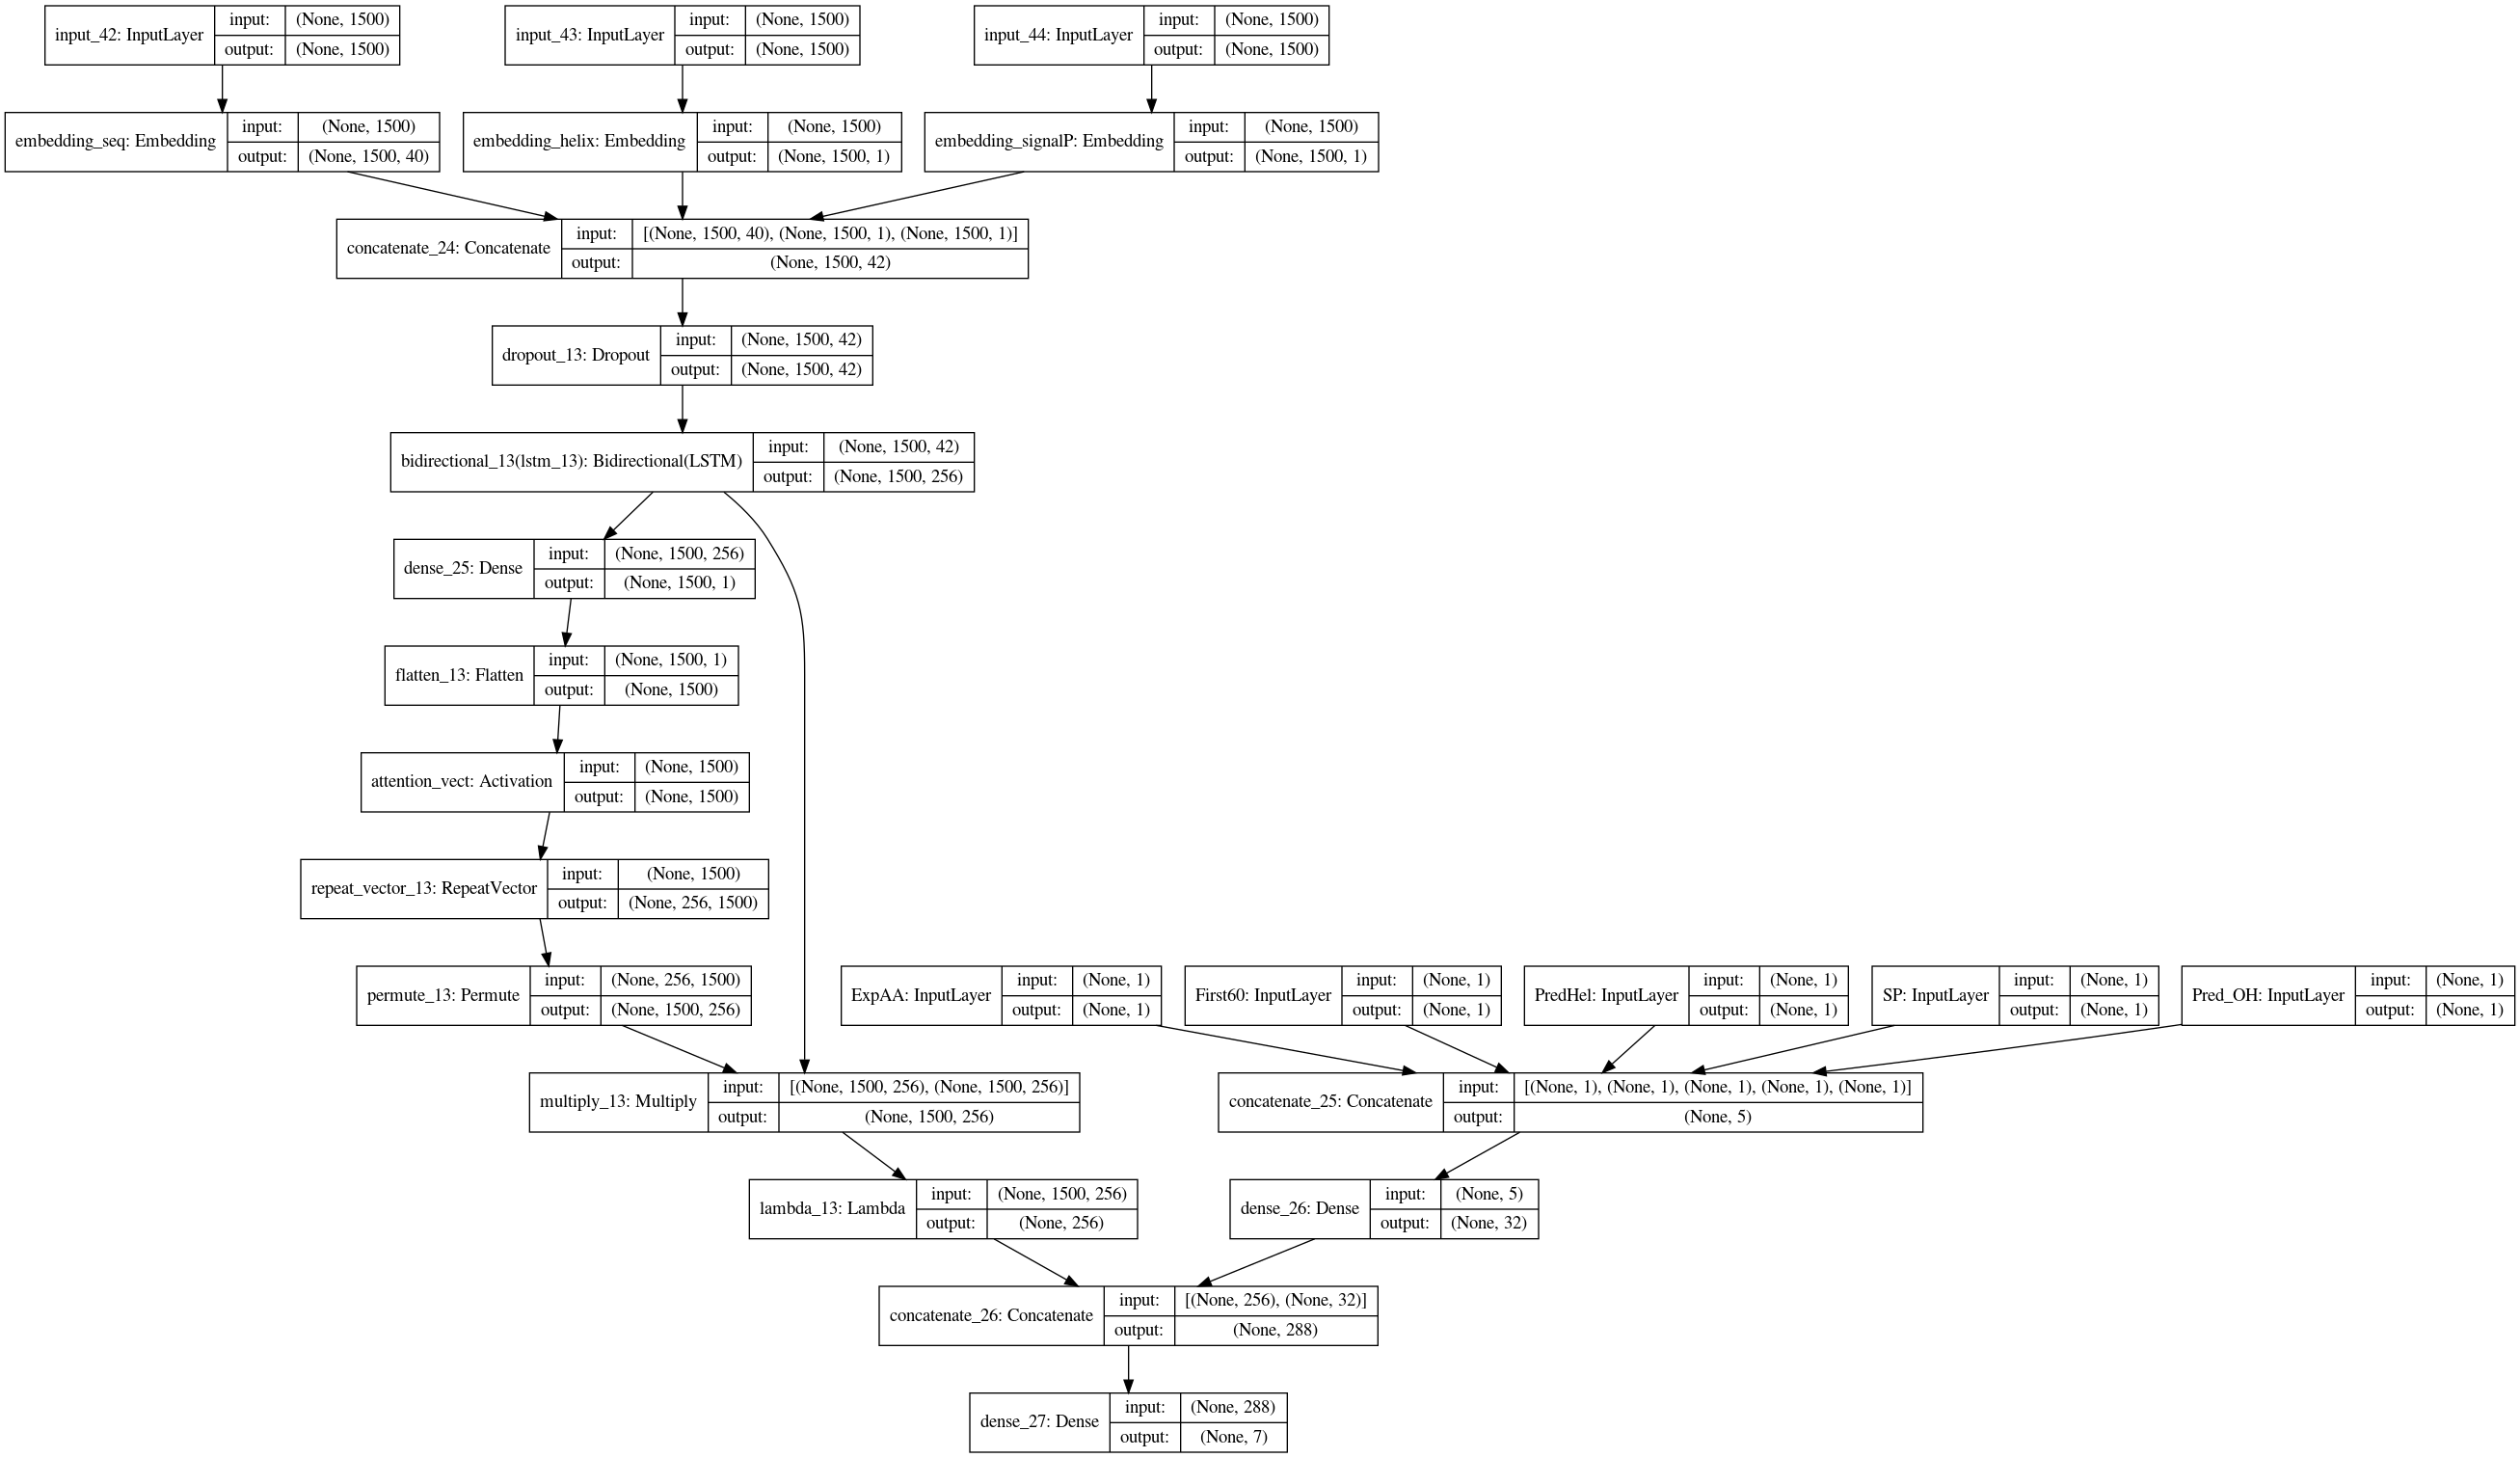

In [103]:
max_aa = tot_aa
max_feature = 2
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 40
feature_embedding_size = 1
# Convolution
filters = 20
pool_size = 2

input_seq = Input(shape=[max_len], dtype='int32')
input_helix = Input(shape=[max_len], dtype='int32')
input_signalP = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded_seq = Embedding(input_dim=max_aa,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_seq', trainable=True, mask_zero=False)(input_seq)

embedded_helix = Embedding(input_dim=max_feature,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_helix', trainable=True, mask_zero=False)(input_helix)

embedded_signalP = Embedding(input_dim=max_feature,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_signalP', trainable=True, mask_zero=False)(input_signalP)

concat_input = concatenate([embedded_seq, embedded_helix, embedded_signalP], axis=2)

drop = Dropout(0.2)(concat_input)
# Convolution layer of different size


activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(drop)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

# Numerical features
input_ExpAA = Input(shape=(1,), name="ExpAA", dtype="float32")
input_First60 = Input(shape=(1,), name="First60", dtype="float32")
input_PredHel = Input(shape=(1,), name="PredHel", dtype="float32")
input_SP = Input(shape=(1,), name="SP", dtype="float32")
input_Pred_OH = Input(shape=(1,), name="Pred_OH", dtype="float32")


concat_feat = concatenate([input_ExpAA, input_First60, input_PredHel, input_SP, input_Pred_OH])
dense = Dense(32, activation="relu")(concat_feat)

concat_all = concatenate([sent_representation, dense])

probabilities = Dense(7, activation='softmax')(concat_all)

model3 = Model(inputs=[input_seq, input_helix, input_signalP, input_ExpAA, input_First60, input_PredHel, input_SP, input_Pred_OH], outputs=probabilities)

plot_model(model3, to_file='models_simpleLSTM/model3_plot.png', show_shapes=True, show_layer_names=True)

In [83]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model3.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_simpleLSTM/model3_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history3 = model3.fit([x_train_pad, train_helix_pad, train_signalP_pad, 
                      ExpAA_train, First60_train, PredHel_train, SP_train, oh_pred_train], y_train_OH, 
                    batch_size=32, epochs=80,
                    class_weight = class_weights,
          validation_data=[[x_valid_pad, valid_helix_pad, valid_signalP_pad,
                           ExpAA_valid, First60_valid, PredHel_valid, SP_valid, oh_pred_valid], y_valid_OH], callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 3229 samples, validate on 710 samples
Epoch 1/80
3229/3229 [==============================] - 391s 121ms/step - loss: 1.5338 - accuracy: 0.5751 - val_loss: 1.2418 - val_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to 1.24176, saving model to models_simpleLSTM/model3_weights.hdf5
Epoch 2/80
3229/3229 [==============================] - 360s 111ms/step - loss: 1.2506 - accuracy: 0.6033 - val_loss: 1.2055 - val_accuracy: 0.6254

Epoch 00002: val_loss improved from 1.24176 to 1.20552, saving model to models_simpleLSTM/model3_weights.hdf5
Epoch 3/80
3229/3229 [==============================] - 322s 100ms/step - loss: 1.2128 - accuracy: 0.6191 - val_loss: 1.1937 - val_accuracy: 0.6254

Epoch 00003: val_loss improved from 1.20552 to 1.19366, saving model to models_simpleLSTM/model3_weights.hdf5
Epoch 4/80
3229/3229 [==============================] - 325s 101ms/step - loss: 1.1913 - accuracy: 0.6222 - val_loss: 1.1706 - val_a


Epoch 00035: val_loss did not improve from 0.93724
Epoch 36/80
3229/3229 [==============================] - 310s 96ms/step - loss: 0.9208 - accuracy: 0.7200 - val_loss: 0.9362 - val_accuracy: 0.7056

Epoch 00036: val_loss improved from 0.93724 to 0.93616, saving model to models_simpleLSTM/model3_weights.hdf5
Epoch 37/80
3229/3229 [==============================] - 313s 97ms/step - loss: 0.9291 - accuracy: 0.7169 - val_loss: 0.9343 - val_accuracy: 0.7155

Epoch 00037: val_loss improved from 0.93616 to 0.93435, saving model to models_simpleLSTM/model3_weights.hdf5
Epoch 38/80
3229/3229 [==============================] - 312s 97ms/step - loss: 0.9179 - accuracy: 0.7210 - val_loss: 0.9295 - val_accuracy: 0.7268

Epoch 00038: val_loss improved from 0.93435 to 0.92953, saving model to models_simpleLSTM/model3_weights.hdf5
Epoch 39/80
3229/3229 [==============================] - 310s 96ms/step - loss: 0.9074 - accuracy: 0.7222 - val_loss: 0.9288 - val_accuracy: 0.7085

Epoch 00039: val_loss 

3229/3229 [==============================] - 310s 96ms/step - loss: 0.7305 - accuracy: 0.7711 - val_loss: 0.8645 - val_accuracy: 0.7352

Epoch 00073: val_loss did not improve from 0.86122
Epoch 74/80
3229/3229 [==============================] - 310s 96ms/step - loss: 0.7085 - accuracy: 0.7779 - val_loss: 0.8885 - val_accuracy: 0.7338

Epoch 00074: val_loss did not improve from 0.86122
Epoch 75/80
3229/3229 [==============================] - 312s 97ms/step - loss: 0.6994 - accuracy: 0.7869 - val_loss: 0.8746 - val_accuracy: 0.7296

Epoch 00075: val_loss did not improve from 0.86122
Epoch 76/80
3229/3229 [==============================] - 310s 96ms/step - loss: 0.6930 - accuracy: 0.7857 - val_loss: 0.8683 - val_accuracy: 0.7310

Epoch 00076: val_loss did not improve from 0.86122
Epoch 77/80
3229/3229 [==============================] - 310s 96ms/step - loss: 0.6771 - accuracy: 0.7891 - val_loss: 0.8944 - val_accuracy: 0.7437

Epoch 00077: val_loss did not improve from 0.86122
Epoch 78/80


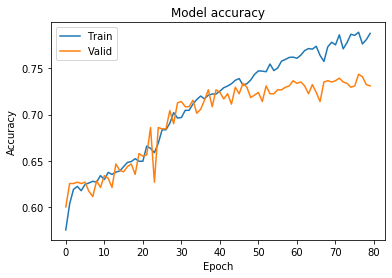

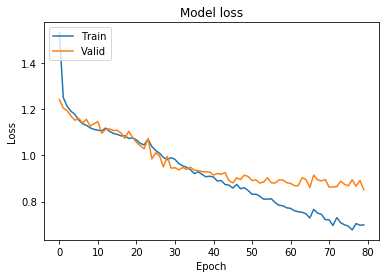

In [86]:
history_plot(history3)

In [87]:
model3 = load_model('models_simpleLSTM/model3_weights.hdf5')
model3.evaluate([x_valid_pad, valid_helix_pad, valid_signalP_pad,
                ExpAA_valid, First60_valid, PredHel_valid, SP_valid, oh_pred_valid], y_valid_OH, verbose=0)

[0.850874975701453, 0.7309859395027161]

In [96]:
y_pred3 = model3.predict([x_valid_pad, valid_helix_pad, valid_signalP_pad,
                ExpAA_valid, First60_valid, PredHel_valid, SP_valid, oh_pred_valid])
y_pred_indices3 = OH_to_label_indices(y_pred3)
y_pred_label3 = indices_to_cat(y_pred_indices3)

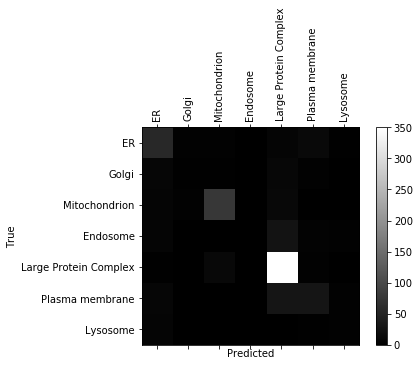

In [97]:
confusion_plot(y_valid, y_pred_label3, cat)

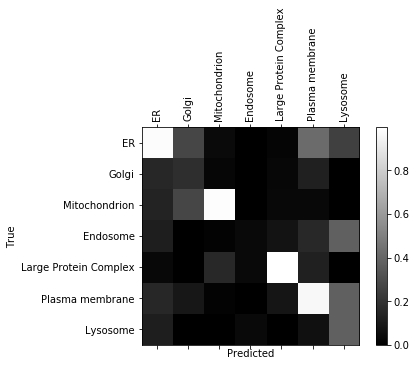

array([[ 57,   3,   3,   0,   7,  13,   2],
       [  9,   2,   2,   0,  10,   4,   0],
       [  8,   3,  76,   0,  12,   1,   0],
       [  7,   0,   1,   1,  26,   5,   3],
       [  2,   0,  12,   1, 350,   4,   0],
       [  9,   1,   1,   0,  29,  30,   3],
       [  7,   0,   0,   1,   0,   2,   3]])

In [98]:
confusion_plot_norm(y_valid, y_pred_label3, cat, axis=1)

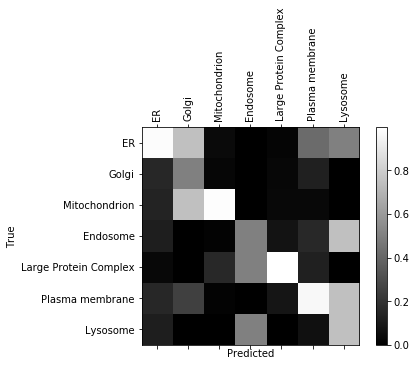

array([[ 57,   3,   3,   0,   7,  13,   2],
       [  9,   2,   2,   0,  10,   4,   0],
       [  8,   3,  76,   0,  12,   1,   0],
       [  7,   0,   1,   1,  26,   5,   3],
       [  2,   0,  12,   1, 350,   4,   0],
       [  9,   1,   1,   0,  29,  30,   3],
       [  7,   0,   0,   1,   0,   2,   3]])

In [100]:
confusion_plot_norm(y_valid, y_pred_label3, cat, axis=0)

In [101]:
print(classification_report(y_valid, y_pred_label3))

                       precision    recall  f1-score   support

                   ER       0.58      0.67      0.62        85
             Endosome       0.33      0.02      0.04        43
                Golgi       0.22      0.07      0.11        27
Large Protein Complex       0.81      0.95      0.87       369
             Lysosome       0.27      0.23      0.25        13
        Mitochondrion       0.80      0.76      0.78       100
      Plasma membrane       0.51      0.41      0.45        73

             accuracy                           0.73       710
            macro avg       0.50      0.45      0.45       710
         weighted avg       0.69      0.73      0.70       710



In [ ]:
                       precision    recall  f1-score   support

                   ER       0.59      0.64      0.61        85
             Endosome       0.25      0.05      0.08        43
                Golgi       0.75      0.11      0.19        27
Large Protein Complex       0.81      0.97      0.88       369
             Lysosome       0.00      0.00      0.00        13
        Mitochondrion       0.85      0.82      0.84       100
      Plasma membrane       0.43      0.40      0.41        73

             accuracy                           0.74       710
            macro avg       0.53      0.43      0.43       710
         weighted avg       0.70      0.74      0.70       710

# Model 4: 

Variation on the features model 

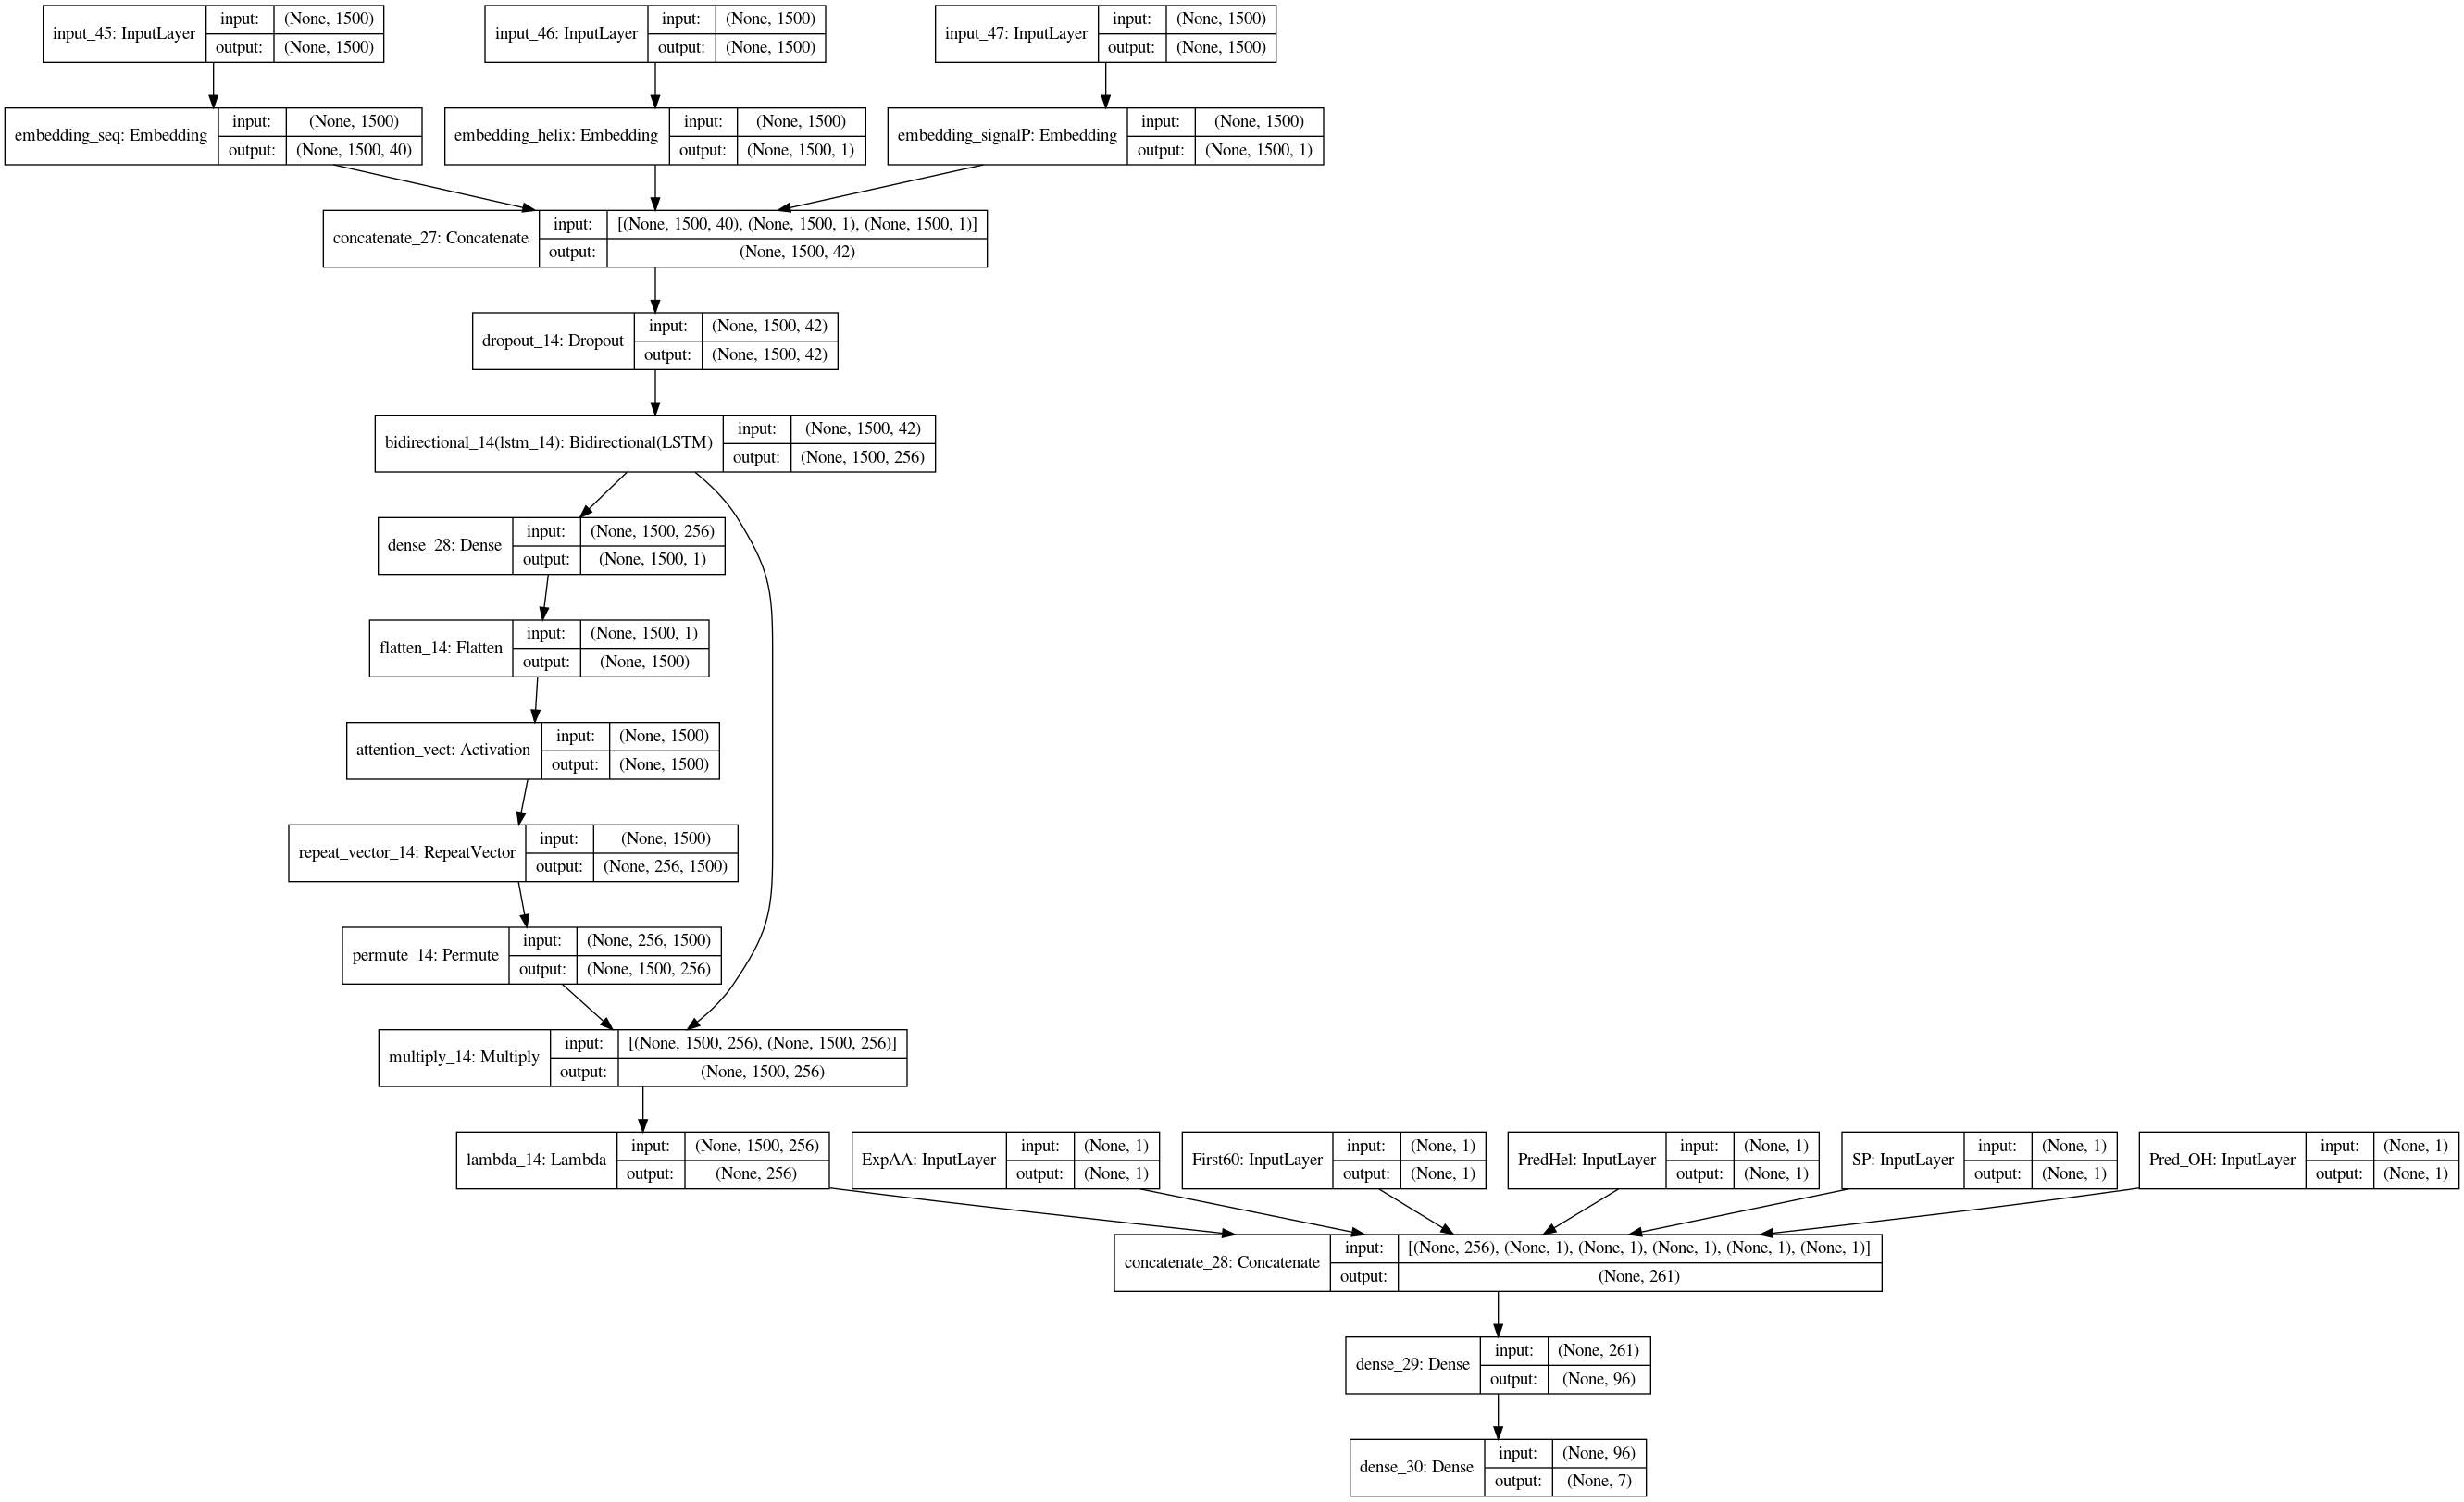

In [105]:
max_aa = tot_aa
max_feature = 2
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 40
feature_embedding_size = 1
# Convolution
filters = 20
pool_size = 2

input_seq = Input(shape=[max_len], dtype='int32')
input_helix = Input(shape=[max_len], dtype='int32')
input_signalP = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded_seq = Embedding(input_dim=max_aa,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_seq', trainable=True, mask_zero=False)(input_seq)

embedded_helix = Embedding(input_dim=max_feature,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_helix', trainable=True, mask_zero=False)(input_helix)

embedded_signalP = Embedding(input_dim=max_feature,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_signalP', trainable=True, mask_zero=False)(input_signalP)

concat_input = concatenate([embedded_seq, embedded_helix, embedded_signalP], axis=2)

drop = Dropout(0.2)(concat_input)
# Convolution layer of different size


activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(drop)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

# Numerical features
input_ExpAA = Input(shape=(1,), name="ExpAA", dtype="float32")
input_First60 = Input(shape=(1,), name="First60", dtype="float32")
input_PredHel = Input(shape=(1,), name="PredHel", dtype="float32")
input_SP = Input(shape=(1,), name="SP", dtype="float32")
input_Pred_OH = Input(shape=(1,), name="Pred_OH", dtype="float32")

concat_feat = concatenate([sent_representation, input_ExpAA, input_First60, input_PredHel, input_SP, input_Pred_OH])
dense = Dense(96, activation="relu")(concat_feat)

probabilities = Dense(7, activation='softmax')(dense)

model4 = Model(inputs=[input_seq, input_helix, input_signalP, input_ExpAA, input_First60, input_PredHel, input_SP, input_Pred_OH], outputs=probabilities)

plot_model(model4, to_file='models_simpleLSTM/model4_plot.png', show_shapes=True, show_layer_names=True)

In [106]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model4.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models_simpleLSTM/model4_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history4 = model4.fit([x_train_pad, train_helix_pad, train_signalP_pad, 
                      ExpAA_train, First60_train, PredHel_train, SP_train, oh_pred_train], y_train_OH, 
                    batch_size=32, epochs=90,
                    class_weight = class_weights,
          validation_data=[[x_valid_pad, valid_helix_pad, valid_signalP_pad,
                           ExpAA_valid, First60_valid, PredHel_valid, SP_valid, oh_pred_valid], y_valid_OH], callbacks=[ckpt])

Train on 3229 samples, validate on 710 samples
Epoch 1/90
3229/3229 [==============================] - 370s 115ms/step - loss: 1.4173 - accuracy: 0.5754 - val_loss: 1.5749 - val_accuracy: 0.5592

Epoch 00001: val_loss improved from inf to 1.57493, saving model to models_simpleLSTM/model4_weights.hdf5
Epoch 2/90
3229/3229 [==============================] - 322s 100ms/step - loss: 1.2803 - accuracy: 0.5999 - val_loss: 1.2312 - val_accuracy: 0.6197

Epoch 00002: val_loss improved from 1.57493 to 1.23116, saving model to models_simpleLSTM/model4_weights.hdf5
Epoch 3/90
3229/3229 [==============================] - 338s 105ms/step - loss: 1.2212 - accuracy: 0.6151 - val_loss: 1.2360 - val_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 1.23116
Epoch 4/90
3229/3229 [==============================] - 318s 98ms/step - loss: 1.2209 - accuracy: 0.6191 - val_loss: 1.1891 - val_accuracy: 0.6310

Epoch 00004: val_loss improved from 1.23116 to 1.18913, saving model to models_simpleLSTM/m

3229/3229 [==============================] - 326s 101ms/step - loss: 0.8777 - accuracy: 0.7293 - val_loss: 0.8996 - val_accuracy: 0.7183

Epoch 00036: val_loss did not improve from 0.87453
Epoch 37/90
3229/3229 [==============================] - 341s 106ms/step - loss: 0.8660 - accuracy: 0.7259 - val_loss: 0.9108 - val_accuracy: 0.7239

Epoch 00037: val_loss did not improve from 0.87453
Epoch 38/90
3229/3229 [==============================] - 325s 101ms/step - loss: 0.8697 - accuracy: 0.7290 - val_loss: 0.8880 - val_accuracy: 0.7211

Epoch 00038: val_loss did not improve from 0.87453
Epoch 39/90
3229/3229 [==============================] - 325s 101ms/step - loss: 0.8394 - accuracy: 0.7380 - val_loss: 0.8798 - val_accuracy: 0.7324

Epoch 00039: val_loss did not improve from 0.87453
Epoch 40/90
3229/3229 [==============================] - 325s 101ms/step - loss: 0.8120 - accuracy: 0.7470 - val_loss: 0.8713 - val_accuracy: 0.7352

Epoch 00040: val_loss improved from 0.87453 to 0.87131, sa


Epoch 00075: val_loss did not improve from 0.83798
Epoch 76/90
3229/3229 [==============================] - 327s 101ms/step - loss: 0.5540 - accuracy: 0.8145 - val_loss: 0.9567 - val_accuracy: 0.7197

Epoch 00076: val_loss did not improve from 0.83798
Epoch 77/90
3229/3229 [==============================] - 327s 101ms/step - loss: 0.5643 - accuracy: 0.8139 - val_loss: 0.9492 - val_accuracy: 0.7211

Epoch 00077: val_loss did not improve from 0.83798
Epoch 78/90
3229/3229 [==============================] - 325s 101ms/step - loss: 0.5213 - accuracy: 0.8238 - val_loss: 0.9547 - val_accuracy: 0.7408

Epoch 00078: val_loss did not improve from 0.83798
Epoch 79/90
3229/3229 [==============================] - 325s 101ms/step - loss: 0.5168 - accuracy: 0.8269 - val_loss: 0.9339 - val_accuracy: 0.7127

Epoch 00079: val_loss did not improve from 0.83798
Epoch 80/90
3229/3229 [==============================] - 326s 101ms/step - loss: 0.5179 - accuracy: 0.8300 - val_loss: 0.9793 - val_accuracy: 0.

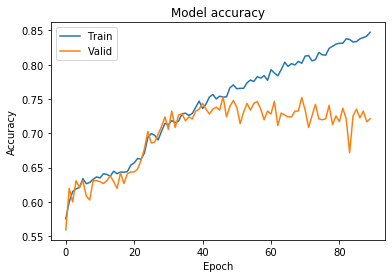

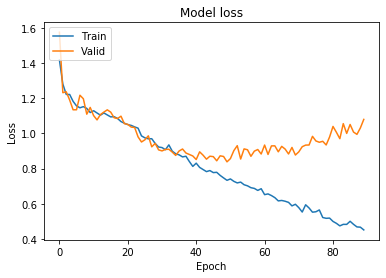

In [107]:
history_plot(history4)

In [108]:
model4 = load_model('models_simpleLSTM/model4_weights.hdf5')
model4.evaluate([x_valid_pad, valid_helix_pad, valid_signalP_pad,
                ExpAA_valid, First60_valid, PredHel_valid, SP_valid, oh_pred_valid], y_valid_OH, verbose=0)

[0.8379838339039977, 0.7478873133659363]

In [109]:
y_pred4 = model4.predict([x_valid_pad, valid_helix_pad, valid_signalP_pad,
                ExpAA_valid, First60_valid, PredHel_valid, SP_valid, oh_pred_valid])
y_pred_indices4 = OH_to_label_indices(y_pred4)
y_pred_label4 = indices_to_cat(y_pred_indices4)

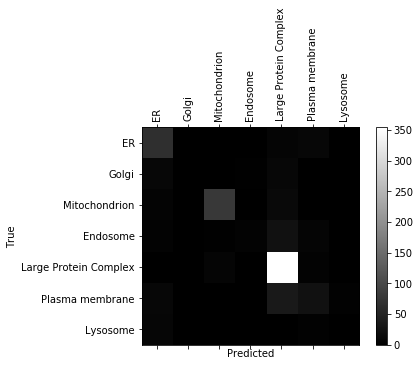

In [110]:
confusion_plot(y_valid, y_pred_label4, cat)

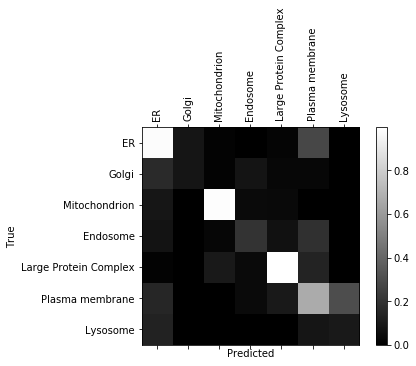

array([[ 66,   1,   1,   0,   7,  10,   0],
       [ 11,   1,   1,   2,  11,   1,   0],
       [  6,   0,  80,   1,  13,   0,   0],
       [  5,   0,   2,   5,  24,   7,   0],
       [  1,   0,   8,   1, 354,   5,   0],
       [ 10,   0,   0,   1,  35,  24,   3],
       [  9,   0,   0,   0,   0,   3,   1]])

In [111]:
confusion_plot_norm(y_valid, y_pred_label4, cat, axis=1)

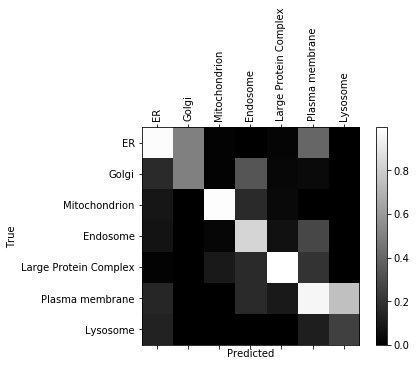

array([[ 66,   1,   1,   0,   7,  10,   0],
       [ 11,   1,   1,   2,  11,   1,   0],
       [  6,   0,  80,   1,  13,   0,   0],
       [  5,   0,   2,   5,  24,   7,   0],
       [  1,   0,   8,   1, 354,   5,   0],
       [ 10,   0,   0,   1,  35,  24,   3],
       [  9,   0,   0,   0,   0,   3,   1]])

In [113]:
confusion_plot_norm(y_valid, y_pred_label4, cat, axis=0)

In [114]:
print(classification_report(y_valid, y_pred_label4))

                       precision    recall  f1-score   support

                   ER       0.61      0.78      0.68        85
             Endosome       0.50      0.12      0.19        43
                Golgi       0.50      0.04      0.07        27
Large Protein Complex       0.80      0.96      0.87       369
             Lysosome       0.25      0.08      0.12        13
        Mitochondrion       0.87      0.80      0.83       100
      Plasma membrane       0.48      0.33      0.39        73

             accuracy                           0.75       710
            macro avg       0.57      0.44      0.45       710
         weighted avg       0.71      0.75      0.71       710



In [ ]:
                       precision    recall  f1-score   support

                   ER       0.59      0.64      0.61        85
             Endosome       0.25      0.05      0.08        43
                Golgi       0.75      0.11      0.19        27
Large Protein Complex       0.81      0.97      0.88       369
             Lysosome       0.00      0.00      0.00        13
        Mitochondrion       0.85      0.82      0.84       100
      Plasma membrane       0.43      0.40      0.41        73

             accuracy                           0.74       710
            macro avg       0.53      0.43      0.43       710
         weighted avg       0.70      0.74      0.70       710

## Embedding Analysis

In [87]:
embedding = model.get_layer('embedding_seq').get_weights()
embedding = embedding[0]
embedding.shape

(22, 40)

In [88]:
embedding2 = model2.get_layer('embedding_seq').get_weights()
embedding2 = embedding2[0]
embedding2.shape

(22, 40)

In [89]:
colors = ['k','tab:orange','b', 'm', 'r', 'g', 'm', 'r', 'tab:orange', 'm', 'g', 'g', 'b', 'g', 'g', 'g',
          'tab:orange', 'tab:orange', 'g', 'g', 'g', 'k']

def plot_embedding(embedding, aa, colors):
    fig, ax = plt.subplots()
    plt.scatter(embedding[:, 0], embedding[:, 1], edgecolor='none', c=colors)
    aaL = list(aa)
    for i in range(len(aaL)):
        ax.annotate(aaL[i], (embedding[:, 0][i], embedding[:, 1][i]))
    
    plt.show()

### PCA plot

original shape:    (22, 40)
transformed shape: (22, 2)


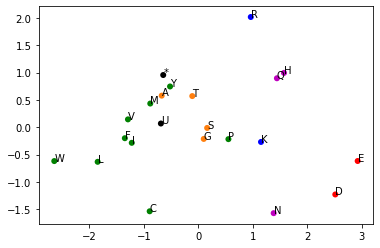

In [90]:
# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)
plot_embedding(embedding_pca, aa, colors)

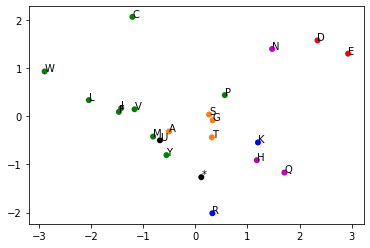

In [91]:
pca.fit(embedding2)
embedding_pca2 = pca.transform(embedding2)
plot_embedding(embedding_pca2, aa, colors)

### t-SNE plot

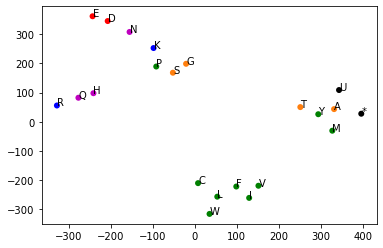

In [92]:
# tSNE plots of Embedding 
tSNE = TSNE(n_components=2, perplexity=3)
embedding_tSNE = tSNE.fit_transform(embedding)
plot_embedding(embedding_tSNE, aa, colors)

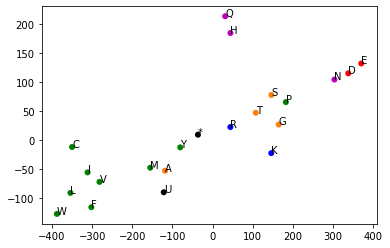

In [93]:
embedding_tSNE2 = tSNE.fit_transform(embedding2)
plot_embedding(embedding_tSNE2, aa, colors)

### UMAP plot

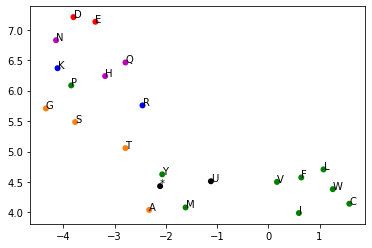

In [94]:
# umap plots of Embedding 
Umap = umap.UMAP(n_components=2, n_neighbors= 6)
embedding_Umap = Umap.fit_transform(embedding)
plot_embedding(embedding_Umap, aa, colors)

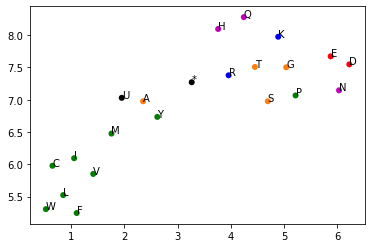

In [95]:
embedding_Umap2 = Umap.fit_transform(embedding2)
plot_embedding(embedding_Umap2, aa, colors)

## Attention Layer Analysis

In [96]:
# Attention for model 1
model1 = load_model('models_simpleLSTM/model1_weights.hdf5')
model1 = Model(inputs=model1.input,
              outputs=[model1.output, model1.get_layer('attention_vect').output])
outputs1 = model1.predict(x_valid_pad)
model_outputs1 = outputs1[0]
attention_outputs1 = outputs1[1]

In [97]:
# Attention for model 2
model2 = load_model('models_simpleLSTM/model2_weights.hdf5')
model2 = Model(inputs=model2.input,
              outputs=[model2.output, model2.get_layer('attention_vect').output])
outputs2 = model2.predict([x_valid_pad, valid_helix_pad, valid_signalP_pad])
model_outputs2 = outputs2[0]
attention_outputs2 = outputs2[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Attention Distribution, Model 1')

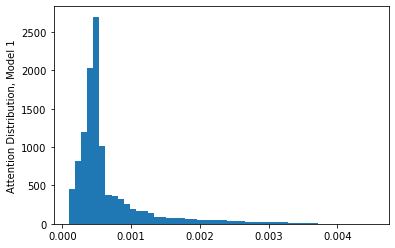

In [98]:
# Processing for Model 1
attention_distrib1 = np.concatenate( attention_outputs1, axis=0 )
plt.hist(attention_distrib1, normed=True, bins=50)
plt.ylabel('Attention Distribution, Model 1')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution, Model 1')

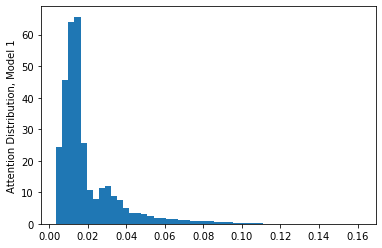

In [99]:
# Normalize attention values 
norm_attention1 = []
for seq in attention_outputs1:
    norm_attention1.append(seq / np.linalg.norm(seq))
    
attention_distrib1 = np.concatenate(norm_attention1, axis=0 )
plt.hist(attention_distrib1, normed=True, bins=50)
plt.ylabel('Attention Distribution, Model 1')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Attention Distribution, Model 2')

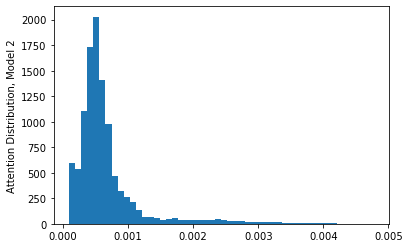

In [100]:
# Processing for Model 2
attention_distrib2 = np.concatenate( attention_outputs2, axis=0 )
plt.hist(attention_distrib2, normed=True, bins=50)
plt.ylabel('Attention Distribution, Model 2')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution, Model 2')

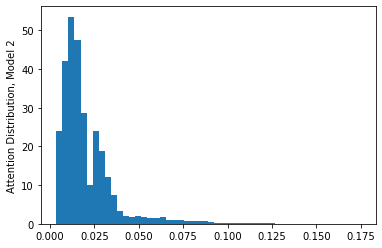

In [101]:
# Normalize attention values 
norm_attention2 = []
for seq in attention_outputs2:
    norm_attention2.append(seq / np.linalg.norm(seq))
    
attention_distrib2 = np.concatenate( norm_attention2, axis=0 )
plt.hist(attention_distrib2, normed=True, bins=50)
plt.ylabel('Attention Distribution, Model 2')

### Attention visualization for a single sequence

Because I pooled (pool size = 2) attention is len = 750. 
So I need to duplicate every values.

In [102]:
def indices_to_seq(X):
    seq = ''
    for i in range(len(X)):
        seq +=int_to_aa[X[i]] 
    return seq

In [108]:
# pool_size = 2
Attention_1500 = []
A = []
for x in norm_attention2:
    for i in range(len(x)):
        A.append(x[i])
    Attention_1500.append(np.array(A))
    A = []

In [109]:
# I don't fully understand that code
# the color_charvals function doesn't work that well because my vector is big
# and the values are very small, I need a better function

class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def color_charvals(s):
    r = 0
    if s.val < 0.07:
        r = 255
    elif s.val > 0.1:
        r = 0
    else:
        r = 255*(1 - (s.val-0.07)/0.03)
    r = int(r)
    color = rgb_to_hex((255, r, 255))
    return 'background-color: %s' % color
    
    #r = int(255/(s.val*10 +1))
    #color = rgb_to_hex((r, r, r))
    #return 'background-color: %s' % color

In [110]:
# Number of highest values to select
nb_max = 30
max_att_indexes = []
for seq in Attention_1500:
    max_att_indexes.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad = []    
for x in range(len(x_valid)):
    max_att_nopad.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [111]:
X = 3

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326
0,M,A,A,A,A,A,A,A,A,A,T,N,G,T,G,G,S,S,G,M,E,V,D,A,A,V,V,P,S,V,M,A,C,G,V,T,G,S,V,S,V,A,L,H,P,L,V,I,L,N,I,S,D,H,W,I,R,M,R,S,Q,E,G,R,P,V,Q,V,I,G,A,L,I,G,K,Q,E,G,R,N,I,E,V,M,N,S,F,E,L,L,S,H,T,V,E,E,K,I,I,I,D,K,E,Y,Y,Y,T,K,E,E,Q,F,K,Q,V,F,K,E,L,E,F,L,G,W,Y,T,T,G,G,P,P,D,P,S,D,I,H,V,H,K,Q,V,C,E,I,I,E,S,P,L,F,L,K,L,N,P,M,T,K,H,T,D,L,P,V,S,V,F,E,S,V,I,D,I,I,N,G,E,A,T,M,L,F,A,E,L,T,Y,T,L,A,T,E,E,A,E,R,I,G,V,D,H,V,A,R,M,T,A,T,G,S,G,E,N,S,T,V,A,E,H,L,I,A,Q,H,S,A,I,K,M,L,H,S,R,V,K,L,I,L,E,Y,V,K,A,S,E,A,G,E,V,P,F,N,H,E,I,L,R,E,A,Y,A,L,C,H,C,L,P,V,L,S,T,D,K,F,K,T,D,F,Y,D,Q,C,N,D,V,G,L,M,A,Y,L,G,T,I,T,K,T,C,N,T,M,N,Q,F,V,N,K,F,N,V,L,Y,D,R,Q,G,I,G,R,R,M,R,G,L,F,F


## Error Analysis

In [112]:
# Make simplified Valid dataset for error Analysis
Val =  valid.drop(['Sequence', 'Topology Seq','Signal Peptide Seq'], 1)

In [113]:
Val.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Prediction,SP(Sec/SPI),CS Position
0,P35269,Large Protein Complex,Very High,517,0.00,0.00,0,[],OTHER,0.000495,[]
1,O75694,Plasma membrane,Medium,1391,0.06,0.00,0,[],OTHER,0.012633,[]
2,P53365,Golgi,Medium,341,0.05,0.00,0,[],OTHER,0.002517,[]
3,Q7L5N1,Large Protein Complex,Very High,327,6.15,6.11,0,[],OTHER,0.003544,[]
4,P54278,Large Protein Complex,Very High,862,0.07,0.00,0,[],OTHER,0.000913,[]


In [114]:
# Add the prediction to Valid dataframe
Val["Model Prediction"] = y_pred_label

In [115]:
Val.groupby(["Compartment Prediction", "Model Prediction"]).count()#/len(valid)*100

Lead Protein ID  \
Compartment Prediction Model Prediction                         
ER                     ER                                  63   
                       Large Protein Complex                6   
                       Mitochondrion                        3   
                       Plasma membrane                     13   
Endosome               ER                                  10   
                       Large Protein Complex               24   
                       Plasma membrane                      9   
Golgi                  ER                                  13   
                       Large Protein Complex               11   
                       Mitochondrion                        2   
                       Plasma membrane                      1   
Large Protein Complex  ER                                   2   
                       Large Protein Complex              361   
                       Mitochondrion                        6   
Lysosome               ER                                  10   
                       Plasma membrane                      3   
Mitochondrion          ER                                  10   
                       Large Protein Complex               11   
                       Mitochondrion                       79   
Plasma membrane        ER                                  17   
                       Large Protein Complex               29   
                       Mitochondrion                        1   
                       Plasma membrane                     26   

                                              Prediction Confidence  \
Compartment Prediction Model Prediction                               
ER                     ER                                        63   
                       Large Protein Complex                      6   
                       Mitochondrion                              3   
                       Plasma membrane                           13   
Endosome               ER                                        10   
                       Large Protein Complex                     24   
                       Plasma membrane                            9   
Golgi                  ER                                        13   
                       Large Protein Complex                     11   
                       Mitochondrion                              2   
                       Plasma membrane                            1   
Large Protein Complex  ER                                         2   
                       Large Protein Complex                    361   
                       Mitochondrion                              6   
Lysosome               ER                                        10   
                       Plasma membrane                            3   
Mitochondrion          ER                                        10   
                       Large Protein Complex                     11   
                       Mitochondrion                             79   
Plasma membrane        ER                                        17   
                       Large Protein Complex                     29   
                       Mitochondrion                              1   
                       Plasma membrane                           26   

                                              Sequence Lengh  ExpAA  First60  \
Compartment Prediction Model Prediction                                        
ER                     ER                                 63     63       63   
                       Large Protein Complex               6      6        6   
                       Mitochondrion                       3      3        3   
                       Plasma membrane                    13     13       13   
Endosome               ER                                 10     10       10   
                       Large Protein Complex              24     24       24   
    

In [116]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [117]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 529 correctly classified exemples
There is 181 incorrectly classified exemples
So the accuracy is: 74.50704225352112


In [118]:
corrects_df = Val[Val.index.isin(corrects)]
corrects_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Prediction,SP(Sec/SPI),CS Position,Model Prediction
0,P35269,Large Protein Complex,Very High,517,0.00,0.00,0,[],OTHER,0.000495,[],Large Protein Complex
3,Q7L5N1,Large Protein Complex,Very High,327,6.15,6.11,0,[],OTHER,0.003544,[],Large Protein Complex
4,P54278,Large Protein Complex,Very High,862,0.07,0.00,0,[],OTHER,0.000913,[],Large Protein Complex
5,Q9NWU5,Mitochondrion,High,206,0.01,0.00,0,[],OTHER,0.007467,[],Mitochondrion
6,O00571,Large Protein Complex,High,662,0.00,0.00,0,[],OTHER,0.001468,[],Large Protein Complex


In [119]:
# Now I use these list of indices to split the valid pandas dataframe
falses_df = Val[Val.index.isin(falses)]
falses_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Prediction,SP(Sec/SPI),CS Position,Model Prediction
1,O75694,Plasma membrane,Medium,1391,0.06,0.00,0,[],OTHER,0.012633,[],Large Protein Complex
2,P53365,Golgi,Medium,341,0.05,0.00,0,[],OTHER,0.002517,[],Large Protein Complex
12,Q15311,Plasma membrane,Low,655,0.00,0.00,0,[],OTHER,0.000878,[],Large Protein Complex
25,O94919,ER,High,500,71.85,0.56,3,"['342-364', '429-451', '461-483']",SP(Sec/SPI),0.974190,['21-22'],Plasma membrane
26,Q658P3,Plasma membrane,Very High,488,126.63,0.08,5,"['214-231', '252-274', '304-323', '361-383', '...",OTHER,0.001021,[],ER


### Checking how low/very low Prediction Confidence proteins are classified

And to a certain extend, low confidence proteins are more often wrongly classified.
It make sense but it is not as bad as I was expecting.

It could make sense to remove these exemples from the dataset altogether. 

In [120]:
falses_df["Prediction Confidence"].value_counts()/ len(falses_df)*100

Very High    27.624309
Medium       24.309392
High         22.099448
Low          17.127072
Very Low      8.839779
Name: Prediction Confidence, dtype: float64

In [121]:
corrects_df["Prediction Confidence"].value_counts()/ len(corrects_df)*100

Very High    40.075614
High         27.410208
Medium       16.635161
Very Low      8.506616
Low           7.372401
Name: Prediction Confidence, dtype: float64

## Checking model on test set 

In [ ]:
test = pd.read_csv("data/7C_test.csv", sep="\t")
y_test = test["Compartment Prediction"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

test_helix = test["Topology Seq"]
test_signalP = test["Signal Peptide Seq"]

test_helix = convert_to_list(test_helix)
test_signalP = convert_to_list(test_signalP)

test_helix_pad = sequence.pad_sequences(test_helix, maxlen=max_len, value=0)
test_signalP_pad = sequence.pad_sequences(test_signalP, maxlen=max_len, value=0)

In [ ]:
model = load_model('models/model1_weights.hdf5')
score = model.evaluate([x_test_pad, test_helix_pad, test_signalP_pad], y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_pred_test = model.predict([x_test_pad, test_helix_pad, test_signalP_pad])
y_pred_indices_test = OH_to_label_indices(y_pred_test)
y_pred_label_test = indices_to_cat(y_pred_indices_test)

conf_mx = confusion_matrix(y_test, y_pred_label_test, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
conf_mx